In [1253]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import requests
import time

In [1254]:
model = tf.keras.models.load_model("../models/model.keras")

In [1255]:
#Read test data
df = pd.read_csv('prices.log', header=None, names=["Price", "Timestamp"])
prices = np.array(df['Price']).reshape(-1, 1)

In [1256]:
#Set min-max scaler to same as model
model_data = pd.read_csv('../resampled_data.csv')
model_prices = np.array(model_data['price'])

# Load the same MinMaxScaler used during training
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = RobustScaler()
scaler.fit(model_prices.reshape(-1, 1))  # Fit on the current live prices

MinMaxScaler()

In [1257]:
#read test data
df.head()

,Price,Timestamp
0,1633.55,2025-04-20T22:21:26.0000000
1,1633.44,2025-04-20T22:21:11.0000000
2,1633.20,2025-04-20T22:20:55.0000000
3,1633.15,2025-04-20T22:20:40.0000000
4,1634.41,2025-04-20T22:20:25.0000000


In [1258]:
df = pd.read_csv('../recent_eth_prices.csv')
#data set is one datapoint every 15 seconds. Want to look once every 3 minutes instead. So we're going to limit our dataset as such
# Make sure 'time' is a datetime object
df['time'] = pd.to_datetime(df['time'])

# Set it as index
df.set_index('time', inplace=True)

minute = 12
# Resample every 6 minutes
df_resampled = df.resample(f'{minute}T').agg({
    'price': 'last',  # Last traded price in the interval
    'size': 'sum',    # Total volume traded in the interval
    'side': lambda x: x.mode()[0] if not x.mode().empty else 'UNKNOWN'  # Most common side or fallback
})

df = df_resampled.reset_index()
df.head()

/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_55867/3945981344.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample(f'{minute}T').agg({


,time,price,size,side
0,2025-02-15 23:00:00+00:00,2694.80,0.014201,SELL
1,2025-02-15 23:12:00+00:00,2696.66,0.626242,SELL
2,2025-02-15 23:24:00+00:00,2696.84,0.394403,SELL
3,2025-02-15 23:36:00+00:00,2690.84,1.337741,SELL
4,2025-02-15 23:48:00+00:00,2693.64,1.082354,SELL


In [1259]:
# Scale prices to match training format
prices_original = df['price'].values.reshape(-1, 1)
df['transformed_price'] = scaler.transform(prices_original)
df['sma_5'] = df['transformed_price'].rolling(window=5).mean()
df['momentum'] = df['transformed_price'] - df['transformed_price'].shift(5)
df['price_scaled'] = scaler.fit_transform(df[['price']])
df['pct_change'] = df['price'].pct_change() * 100  # Convert to percentage
df.dropna(subset=['sma_5', 'momentum'], inplace=True)
df.head()

prices = df['price_scaled'].values
sma_5 = df['sma_5'].values
momentum = df['momentum'].values

In [1260]:
# Prepare the data for LSTM (same sequence length used in training)
X_test = []
last_price = []

# Create sequences of data for LSTM
sequence_length = 10  # Sequence of 10 observations
forecast_steps = 5  # Predict 5 steps into the future

for i in range(0, len((prices) - sequence_length - forecast_steps), sequence_length):
    try:
        #build feature set
        row = []
        row.append(np.array(prices[i:i + sequence_length]).reshape(sequence_length, 1))
        #row.append(np.array(sma_5[i:i + sequence_length]).reshape(sequence_length, 1))
        #row.append(np.array(momentum[i:i + sequence_length]).reshape(sequence_length, 1))

        X_test.append(prices[i:i + sequence_length])
        #X_test.append(np.array(row).reshape(len(row), sequence_length))
        last_price.append(prices_original[i + sequence_length])
    except ValueError:
        break

X_test = np.array(X_test)

In [1261]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions to get actual price values
predicted_prices = scaler.inverse_transform(predictions)
#predicted_prices = predicted_prices[1:]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


In [1262]:
len(predictions)

56

In [1263]:
#pull real prices to compare with predictions
prices_to_compare = []
step_length = 5
for i in range(sequence_length + step_length - 1, len(prices), sequence_length):
    prices_to_compare.append(prices_original[i])

len(prices_to_compare)

56

In [1264]:
def print_percent_diff(A, B):
    # Compute % difference for each element
    percent_diff = np.abs(A - B) / ((A + B) / 2) * 100

    # Compute and print the average percentage difference
    average_percent_diff = np.mean(percent_diff)
    print("Average Percentage Difference:", average_percent_diff)

In [1265]:
print_percent_diff(predicted_prices, prices_to_compare)

Average Percentage Difference: 0.03288605538623401


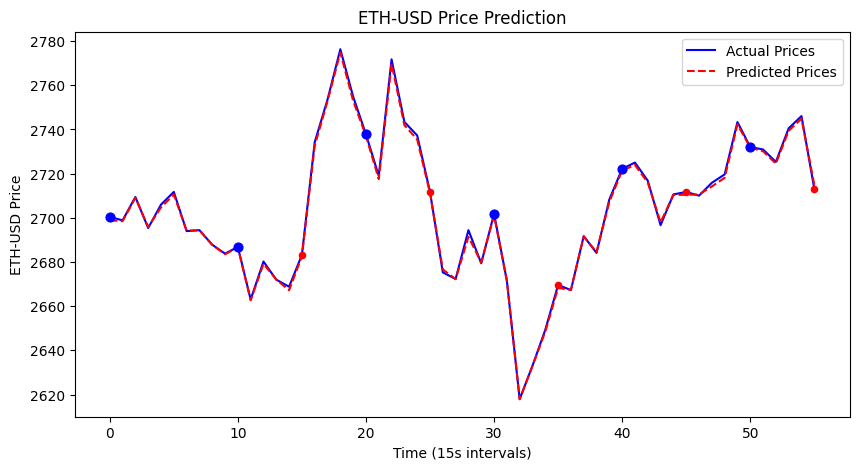

In [1266]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(prices_to_compare, label="Actual Prices", color="blue")
plt.plot(predicted_prices, label="Predicted Prices", color="red", linestyle="dashed")
plt.xlabel("Time (15s intervals)")
plt.ylabel("ETH-USD Price")
plt.legend()
plt.title("ETH-USD Price Prediction")

# Add blue markers every 10 steps
blue_indices = np.arange(0, len(prices_to_compare), sequence_length)
plt.scatter(blue_indices, np.array(prices_to_compare)[blue_indices], color="blue", s=40, label="Blue Marker (Every 10)", zorder=3)

# Add red markers every 5 steps
red_indices = np.arange(sequence_length + forecast_steps, len(prices_to_compare), sequence_length)
plt.scatter(red_indices, np.array(prices_to_compare)[red_indices], color="red", s=20, label="Red Marker (Every 5)", zorder=3)

plt.show()

In [1267]:
correct_buy_predictions = 0
incorrect_buy_predictions = 0
correct_sell_predictions = 0
incorrect_sell_predictions = 0
threshold = 1
skipped_trades = 0
completed_trades = 0
max_percentage = 0

for i in range(len(predicted_prices)):
    # Real price of ETH
    real_price = prices_to_compare[i]
    #Predicted price of ETH
    predicted_price = predicted_prices[i]
    #Price 5 timestamps ago
    previous_price = last_price[i]

    #only make a trade if predicted price difference is greater than the threshold
    if i > 0 and abs(((predicted_price - previous_price)/previous_price) * 100) > max_percentage:
        max_percentage = abs(((predicted_price - previous_price)/previous_price) * 100)

    if i > 0 and abs(((predicted_price - previous_price)/previous_price) * 100) < threshold:
        skipped_trades += 1
        continue

    completed_trades += 1

    #Check if both prediction and real price were up or down
    if (real_price - previous_price > 0 and predicted_price - previous_price > 0):
        correct_buy_predictions += 1
    elif( real_price - previous_price < 0 and predicted_price - previous_price > 0):
        incorrect_buy_predictions += 1
    elif (real_price - previous_price < 0 and predicted_price - previous_price < 0):
        correct_sell_predictions += 1
    elif (real_price - previous_price > 0 and predicted_price - previous_price < 0):
        incorrect_sell_predictions += 1

if correct_sell_predictions + incorrect_sell_predictions > 0:
    print(f"SELL Predictions: {correct_sell_predictions + incorrect_sell_predictions} Correct: {correct_sell_predictions} Incorrect: {incorrect_sell_predictions} Correct Rate: {(correct_sell_predictions/(correct_sell_predictions + incorrect_sell_predictions) * 100)}%")
if correct_buy_predictions + incorrect_buy_predictions > 0:
    print(f"BUY Predictions: {correct_buy_predictions + incorrect_buy_predictions} Correct: {correct_buy_predictions} Incorrect: {incorrect_buy_predictions} Correct Rate: {(correct_buy_predictions/(correct_buy_predictions + incorrect_buy_predictions) * 100)}%")

print(f"Biggest Predicted Change: {max_percentage}%")
print(f"Trades Made: {completed_trades}")
print(f"Trades skipped: {skipped_trades}")
print(f"Trade percentage: {((completed_trades)/(completed_trades + skipped_trades)) * 100}%")
total_correct = correct_buy_predictions + correct_sell_predictions
total_incorrect = incorrect_buy_predictions + incorrect_sell_predictions
print(f"Overall correct rate: {(total_correct/completed_trades)*100}%")


SELL Predictions: 2 Correct: 2 Incorrect: 0 Correct Rate: 100.0%
BUY Predictions: 2 Correct: 2 Incorrect: 0 Correct Rate: 100.0%
Biggest Predicted Change: [2.26352258]%
Trades Made: 4
Trades skipped: 52
Trade percentage: 7.142857142857142%
Overall correct rate: 100.0%


In [1268]:
print(f"--------Model Information--------\r\nInterval: {minute * 60} seconds\r\nsequence_length: {sequence_length}\r\nforecast_steps: {forecast_steps}")

--------Model Information--------
Interval: 720 seconds
sequence_length: 10
forecast_steps: 5
